In [1]:
from utils.draw import draw_custom_weighted_graph
from ga.tsp_ga import TSPGA
from ga.tsp_ga_din_crossover import TSPGA as TSPGAC
from ga.tsp_ga_parallel import TSPGA as TSPGAP

In [2]:
from itertools import permutations
import random
from tqdm import tqdm
def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w

def evaluate_several_options(gas = [], steps_number = 100):
    steps = []
    costs_list = [[] for _ in gas]
    for step in tqdm(range(steps_number), desc="Running RA for all options"):
        for idx, ga in enumerate(gas):
            new_population, new_costs = ga.step()
            tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
            costs_list[idx].append(cost)
        steps.append(step)
    return steps, costs_list

In [3]:
def generate_one_side_grid(params, attribute, values ):
    params_list = []
    labels = []
    for value in values:
        param = params.copy()
        param[attribute] = value
        params_list.append(param)
        labels.append(f"{attribute}:{value}")
    return params_list, labels

In [4]:
import numpy as np
from functools import reduce

def calculate_percentile(value, values):
    # Convert the input values to a numpy array
    values = np.array(values)
    
    # Calculate the percentile rank of the given value
    percentile_rank = (np.sum(values < value) / len(values) * 100)//1
    
    return percentile_rank
    
def calculate_percentiles(costs, comparing_step = 100):
    # Get the final cost for each scenario (the last element in each list)
    flat_costs = reduce(lambda a,b : a+b, costs)
    
    
    # Calculate the percentile rank of the given value
    percentile_rank = [calculate_percentile(cost[comparing_step], flat_costs) for cost in costs]
    
    return percentile_rank


In [5]:
import multiprocessing as mp


def evaluate_several_options_single(ga, steps_number=100):
    steps = []
    costs_list = []
    for step in tqdm(range(steps_number), desc=f"Running GA for single option", leave=False):
        new_population, new_costs = ga.step()
        tour, cost = min(zip(new_population, new_costs), key=lambda el: el[1])
        costs_list.append(cost)
        steps.append(step)
    return steps, costs_list

def evaluate_several_options_parallel(gas, steps_number=100):
    # Create a pool of workers
    with mp.Pool(mp.cpu_count()) as pool:
        # Parallelize the evaluation of all GA instances
        results = pool.starmap(evaluate_several_options_single, [(ga, steps_number) for ga in gas])

    # Unpack the results
    steps = [result[0] for result in results]  # List of step sequences for each GA
    costs_list = [result[1] for result in results]  # List of cost sequences for each GA
    return steps, costs_list

In [6]:

NUM_NODES = 40
nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)

# Optimizing the hyp tunning using Pool

# Without pool

In [8]:
%%time


params = {
"population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
}
params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20)])

gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]

steps, costs = evaluate_several_options(gas=gas, steps_number=100)

Running RA for all options: 100%|█████████████| 100/100 [00:41<00:00,  2.43it/s]

CPU times: user 41.2 s, sys: 5.28 ms, total: 41.2 s
Wall time: 41.2 s


# With pool, running different GA in different workers

In [9]:
%%time


params = {
"population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
}
params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20)])

gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]

steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)

CPU times: user 789 ms, sys: 341 ms, total: 1.13 s
Wall time: 28.3 s


# Finding best population based on number of nodes

In [6]:
%%time

results = {}
cost_dict = {}
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20,2)])
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 2.08 s, sys: 996 ms, total: 3.08 s
Wall time: 4min 33s


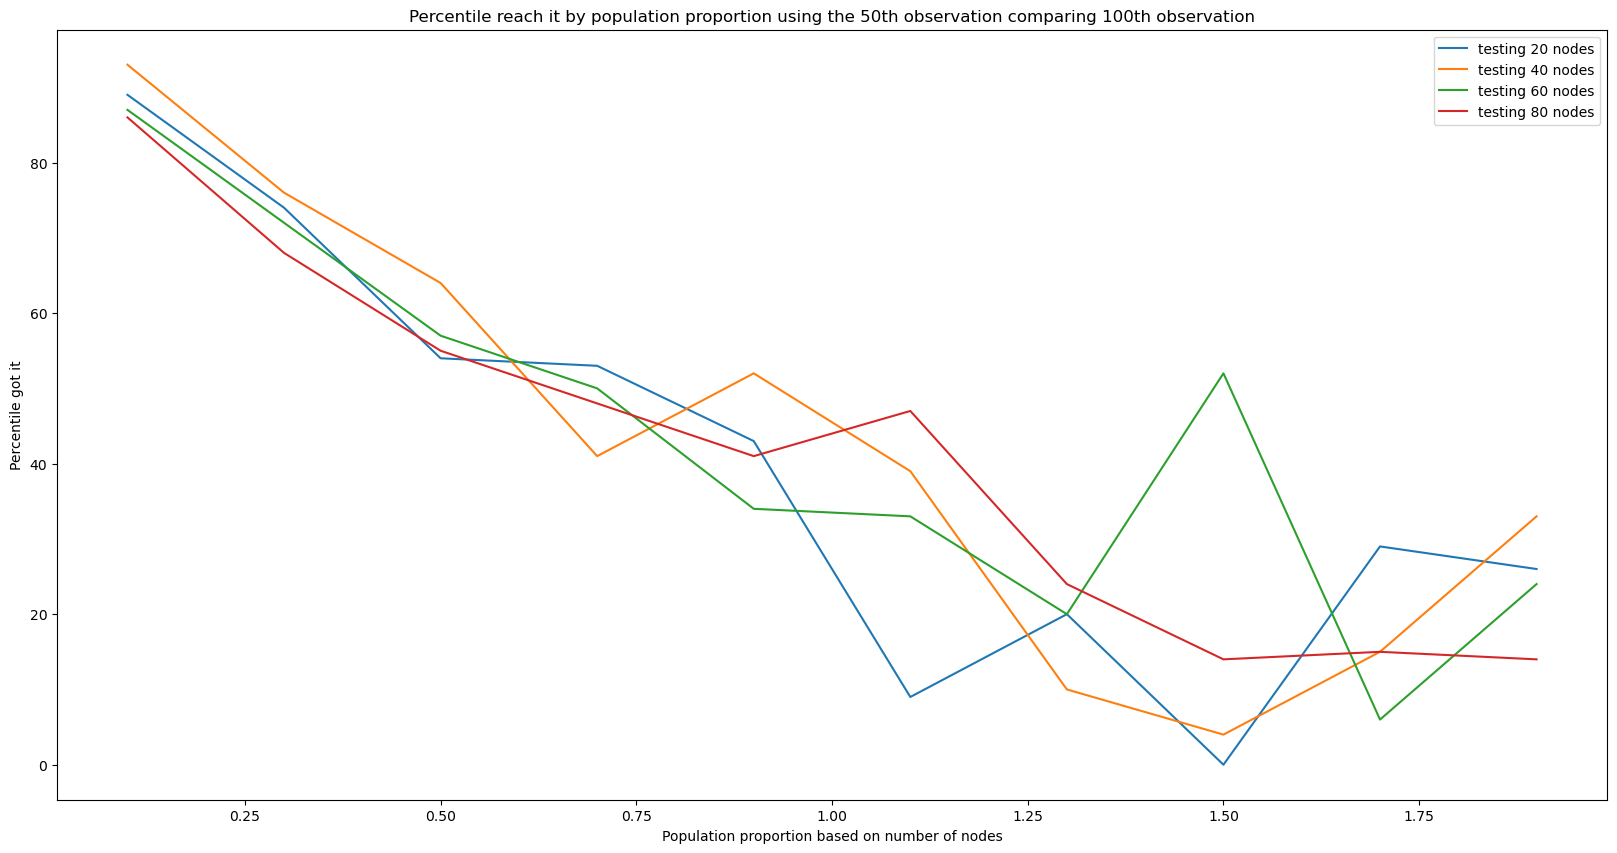

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
for idx, values in results.items():
    sns.lineplot(x =[x/10 for x in range(1,20, 2)], y =values, label=idx)
plt.title("Percentile reach it by population proportion using the 50th observation comparing 100th observation")
plt.xlabel("Population proportion based on number of nodes")
plt.ylabel("Percentile got it")
plt.show()

In [16]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
population_prop:0.1,89.0,93.0,87.0,86.0,88.75
population_prop:0.3,74.0,76.0,72.0,68.0,72.50
population_prop:0.5,54.0,64.0,57.0,55.0,57.50
population_prop:0.7,53.0,41.0,50.0,48.0,48.00
population_prop:0.9,43.0,52.0,34.0,41.0,42.50
population_prop:1.1,9.0,39.0,33.0,47.0,32.00
population_prop:1.3,20.0,10.0,20.0,24.0,18.50
population_prop:1.5,0.0,4.0,52.0,14.0,17.50
population_prop:1.7,29.0,15.0,6.0,15.0,16.25
population_prop:1.9,26.0,33.0,24.0,14.0,24.25


In [20]:
df.to_csv("data/tunning_population_pro.csv")

In [22]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & testing 20 nodes & testing 40 nodes & testing 60 nodes & testing 80 nodes & AVG \\
\midrule
population_prop:0.1 & 89.000000 & 93.000000 & 87.000000 & 86.000000 & 88.750000 \\
population_prop:0.3 & 74.000000 & 76.000000 & 72.000000 & 68.000000 & 72.500000 \\
population_prop:0.5 & 54.000000 & 64.000000 & 57.000000 & 55.000000 & 57.500000 \\
population_prop:0.7 & 53.000000 & 41.000000 & 50.000000 & 48.000000 & 48.000000 \\
population_prop:0.9 & 43.000000 & 52.000000 & 34.000000 & 41.000000 & 42.500000 \\
population_prop:1.1 & 9.000000 & 39.000000 & 33.000000 & 47.000000 & 32.000000 \\
population_prop:1.3 & 20.000000 & 10.000000 & 20.000000 & 24.000000 & 18.500000 \\
population_prop:1.5 & 0.000000 & 4.000000 & 52.000000 & 14.000000 & 17.500000 \\
population_prop:1.7 & 29.000000 & 15.000000 & 6.000000 & 15.000000 & 16.250000 \\
population_prop:1.9 & 26.000000 & 33.000000 & 24.000000 & 14.000000 & 24.250000 \\
\bottomrule
\end{tabular}



In [18]:
print("Using 0.3 vs 1.1 an improvement of: 72.50 - 32.00 = ", 72.50 - 32.00)
print("Compared with 1.1 vs 1.9 an improvement of: 32.00 - 24.25 = ", 32.00 - 24.25)

Using 0.3 vs 1.1 an improvement of: 72.50 - 32.00 =  40.5
Compared with 1.1 vs 1.9 an improvement of: 32.00 - 24.25 =  7.75


### Conclution
1.1 param will be used